# Gravitational wave detection with convolutional neural networks

[Michael J Williams](mailto:m.williams.4@research.gla.ac.uk)


Institute for Gravitational Research 

University of Glasgow

<div style="text-align:center"><img src="https://raw.githubusercontent.com/mj-will/intro2ml/master/docs/assets/igr.jpg" width="100"/></div>

In [Gabbard et al](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.120.141103) convolutional neural networks are used to detect simulated signals from binary black hole coalescence in noisy data. This notebook outlines the approached used with a snippet of the data used in the publication.

A convolutional neural network will used to detect the signals and its performance analysed.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mj-will/intro2ml/blob/master/notebooks/gravitational-wave-detection.ipynb)

In [0]:
import os
from six.moves import cPickle as pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.optimizers import Adam


## Data

Data is available [here](http://www.astro.gla.ac.uk/users/michael/datasets/bbh/BBH_training_1s_1024Hz_10Ksamp_1n_iSNR8_Hdet_astromass_1seed_ts_0.pkl) but this notebook will automatically download it with the following function.

The data consists of time series which will be labelled `x` and labels (no signal/signal) labelled `y`. The dimensions of the time series array will be:
`[number of time series, number of detectors, number of samples]`

The number of samples with depend on the duration and sampling rate, in this example the data is one second long and sampled at 1024Hz.


In [0]:
def fetch_data(url, filename):
    """Fetch data from a url and save it to given file"""
    import urllib
    urllib.request.urlretrieve(url, filename=filename)

In [0]:
# url of the data
data_url = 'http://www.astro.gla.ac.uk/users/michael/datasets/bbh/BBH_training_1s_1024Hz_10Ksamp_1n_iSNR8_Hdet_astromass_1seed_ts_0.pkl'
# path to save the data
data_file = './data.pkl'
# only download the data if the file doesn't already exist
if not os.path.isfile(data_file):
    fetch_data(data_url, data_file)

In [0]:
def load_data(data_file, start=512, length=1024):
    """Load the data and remove the first and last 0.5 seconds of padding"""
    # load the pickled data
    with open(data_file, 'rb') as f:
        x, y = pickle.load(f)
    # ts are 2048 long, so want middle 1024 samples
    x = x[:,:,start:(start+length)]
    print(f'x shape: {x.shape}, y shape: {y.shape}')
    return x, y

In [0]:
x, y = load_data(data_file)

x shape: (10000, 1, 1024), y shape: (10000,)


Once the data is loaded plot one of the time series.

As mentioned before the sampling rate `fs` is 1024Hz and the duration is 1 second.

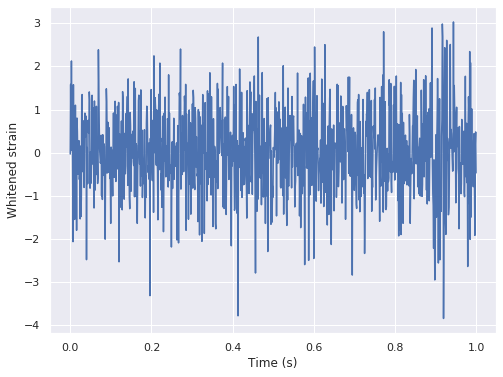

In [0]:
fs = 1024                           # sampling frequency
duration = 1
t = np.arange(0, duration, 1. / fs) # array of time steps
fig = plt.figure(figsize=(8,6))
plt.plot(t, x[0, 0])
plt.xlabel("Time (s)")
plt.ylabel("Whitened strain")
plt.show()

### Labels

In their original forms the labels are simply a list of zeros and ones with zero corresponding to no signal and one correponding to signal. We want the trained neural network to predict these labels as accurately as possible.


In [0]:
print(f'Label vector: {y[:10]}')

Label vector: [1 0 1 1 0 0 1 0 0 1]


Because of the loss function we're going to use this needs to be converted to a matrix form (also known as one-hot encoding).

Keras includes a function to do this automatically.

In [0]:
num_classes = 2
y_cat = keras.utils.to_categorical(y, num_classes)
print(f'Label matrices: {y_cat[:10]}')

Label matrices: [[0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]]


Where the first column now corresponds to noise and the second to signal. So `[1. 0.]` indicates noise and `[0. 1.]` indicates a signal.

### Training/testing split

We reserve some of the data to use after training. This is used to test the network peformance on unseen data.

In this case we reserve 10% of the data.

In [0]:
n_train = int(0.9 * x.shape[0])
x_train, x_test = x[:n_train], x[n_train:]
y_train, y_test = y_cat[:n_train], y_cat[n_train:]


## General parameters

We need to define some general parameters for networks we're going to use:

* Batch size: refers to the number of images/samples passed to the network in a single instance of training
* Input shape: defines the shape of the input to the network, the batch size is ignored so we only specify the number of channels(detectors) and the length of the time series.
* Epochs: refers to the number of times the network will train on the complete dataset



In [0]:
batch_size = 50              # number of samples in each batch of training data
input_shape = [1, 1024]      # shape of the data
n_epochs = 10                # number of epochs to train for

## The model

We now need to construct the neural network that we're going to training to classify the data.

We start by defining the type of keras model. In this case we're using `Sequential`. When using this type of model any layers we add are assumed to directly follow from the previous one. The other type is Model which you can read about here.

We then add the input layer. In this case we're going to use a 1D covolutional layer (`Conv1D`) layer. We need to specify the number of neurons, the size of the filter (or kernel), the activation function and the shape of the input with keyword argument input_shape. We also specifiy the order of the data to be `channels_first`.

We then add 1D Max-pooling which will reduce the dimensions of data being passed to the next layer by taking the maximum value in blocks of a given size (in this case 4).

We the repeat the convolution + max-pooling combination again.

This is followed by a `Dense` layer (or fully-connected), which requieres a flat input so we also add a flattening layer. For dense layer we only need to specifiy the number of neurons and the activation function.

Finally we the output layer. Since this is a classifcation task we want the network to predict one of the two classes, so we use two neurons. As for the activation function, we use a softmax function since this ensures the sum of all the output is one, so they can be thought of as a sort of probability.

In [0]:
model = Sequential()
model.add(Conv1D(16, 
                 kernel_size=16, 
                 input_shape=input_shape, 
                 activation='relu',
                 data_format='channels_first'))
model.add(MaxPooling1D(pool_size=4))
model.add(Conv1D(16, 
                 kernel_size=16, 
                 activation='relu',
                 data_format='channels_first'))
model.add(MaxPooling1D(pool_size=4))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(2, activation='softmax'))
print(model.summary())

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16, 1009)          272       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 4, 1009)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16, 994)           1040      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 4, 994)            0         
_________________________________________________________________
flatten (Flatten)            (None, 3976)              0         
_________________________________________________________________
dense (Dense)                (None, 32)                127264    
_________________________________________

### Compiling

In Keras the model must be compiled before training. It's at this stage that we specify the loss function to use and what optimiser to use.

The **optimiser** is the algorithm that is used to explore the parameter space of the network weights. In this example we're going to use `Adam` with a learning rate of 0.001 and the other parameters left as their default values. There a various different optimisers to choose from but Adam has proven to be realiable for a wide variety of problems and is a good place to start.

We then need to define the function that will quantify the network's performance, the **loss function**. In this case we're using **Categorical Crossentropy**. This combined with the **Softmax layer** means the network will ouput a vector of probabilities for each samples where each probability corresponds to a particular class.

For this binary (noise/signal) case it can written as:

$$f(\theta) = - \sum_{i \in S} log(\theta_{i}^{S}) - \sum_{i \in N} log(\theta_{i}^{N})$$

where $\theta_{i}^{S/N}$ is the predicted probability of class signal-noise (S) or noise-only (N)

We can also add **metrics** which are not used during training but give us anthoer indication of the networks performance. Since this is a classification problem we'll use accurary.


In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001), metrics=['accuracy'])

## Training

We're now ready to train the network. The model class has a method called `fit` that trains the model given some inputs. This is simplest way to train a model but has some limitations, for example when dealing with very large datasets that can't be loaded into memory.

A portion of the data (the validation set) is used to keep track of the networks performance during training. Importantly it is never used to update the networks parameters.

In [0]:
history = model.fit(x_train, y_train, validation_split=0.2, batch_size=batch_size, epochs=n_epochs)

Train on 7200 samples, validate on 1800 samples
Epoch 1/10
7200/7200 [==============================] - 2s 295us/sample - loss: 0.7002 - acc: 0.4992 - val_loss: 0.6931 - val_acc: 0.4989
Epoch 2/10
7200/7200 [==============================] - 1s 95us/sample - loss: 0.6932 - acc: 0.4975 - val_loss: 0.6932 - val_acc: 0.4967
Epoch 3/10
7200/7200 [==============================] - 1s 93us/sample - loss: 0.6904 - acc: 0.5221 - val_loss: 0.6489 - val_acc: 0.5583
Epoch 4/10
7200/7200 [==============================] - 1s 93us/sample - loss: 0.5124 - acc: 0.7851 - val_loss: 0.4024 - val_acc: 0.8622
Epoch 5/10
7200/7200 [==============================] - 1s 93us/sample - loss: 0.4040 - acc: 0.8647 - val_loss: 0.3586 - val_acc: 0.8989
Epoch 6/10
7200/7200 [==============================] - 1s 95us/sample - loss: 0.3315 - acc: 0.8983 - val_loss: 0.2908 - val_acc: 0.9111
Epoch 7/10
7200/7200 [==============================] - 1s 92us/sample - loss: 0.2835 - acc: 0.9168 - val_loss: 0.2606 - val_acc:

## Evaluation

Now that the network in trained we can analyse the output to understand how well it has learn to predict the classes.

### Loss function

We can plot the loss function to see how network learned over the epochs, we can also include the validation set which was never used to train the network.

We can use the `history` object returned by `fit` to do this.


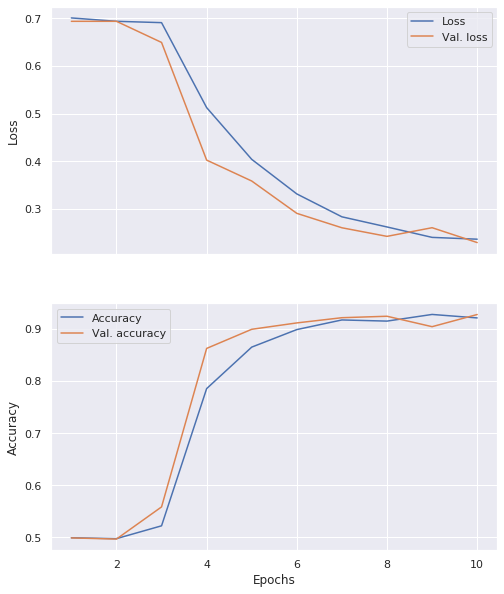

In [0]:
# set up the figure
fig, axs = plt.subplots(2, 1, figsize=(8, 10), sharex=True)
axs = axs.ravel()     # flattens the array of axes so it's easier to index
epochs = np.arange(1, n_epochs+1)
# plot the loss
axs[0].plot(epochs, history.history['loss'], label='Loss')
axs[0].plot(epochs, history.history['val_loss'], label='Val. loss')
# plot accuracy
axs[1].plot(epochs, history.history['acc'], label='Accuracy')
axs[1].plot(epochs, history.history['val_acc'], label='Val. accuracy')
# labels
axs[1].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[1].set_ylabel("Accuracy")
axs[0].legend()
axs[1].legend()
plt.show()

### Predictions

We can easily get predictions for the testing set or any other data we might have using the trained model. We will use these to quantify the networks performance.

In [0]:
y_pred = model.predict(x_test)

### Confusion matrix

A confusion matrix allows us to visualise what classes the network is predicting correctly or incorrectly.

In this case we may want to minimise the number of false positives (noise classified as signal) rather than maximise the number of true positives.

Scikit-learn includes lots of useful functions to compute metrics like confusion matrices and ROC curves (which we will see later on)

In [0]:
from sklearn import metrics

In order to compute the confusion matrix we need the predicted classes rather than their probabilites. We get these by simply taking the class with the maximum probability for each time series.

In [0]:
pred_class = np.argmax(y_pred, axis=1)
true_class = np.argmax(y_test, axis=1)

We can now compute the confusion matrix

In [0]:
cm = metrics.confusion_matrix(true_class, pred_class)

We're going to use `Seaborn` to plot the confusion matrix

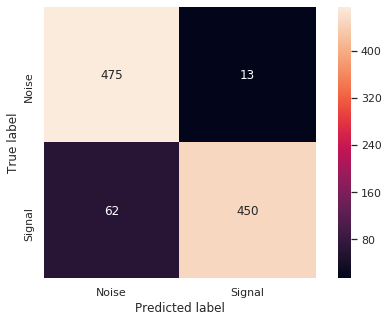

In [0]:
fig = plt.figure(figsize=(8, 5))
sns.heatmap(cm, annot=True, square=True, fmt='g', 
            xticklabels=['Noise', 'Signal'], yticklabels=['Noise', 'Signal'])
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

## ROC curves

Reciever operator characteristic curves are another way of quatifying the network's performance. It's a plot of the true positive rate (probability of detection) against the false positive rate (probabilty of false alarm).

We use Scikit learn again to compute the ROC curve, but this time we use the probabilites instead of the classes. Importantly we use the probability of the a time series being a signal (the second column in the matrix representation).

In [0]:
# [:, 1] for second column
fa, ta, _ = metrics.roc_curve(y_test[:,1], y_pred[:,1])

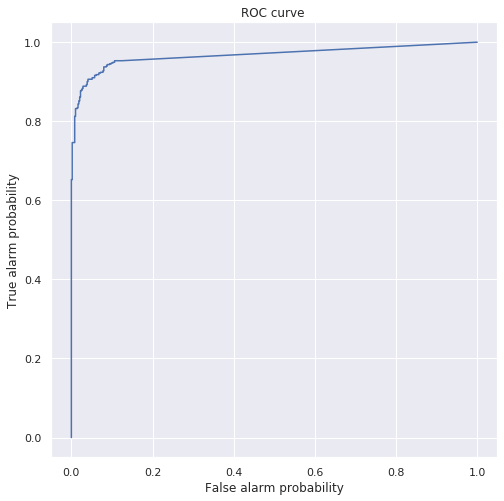

In [0]:
fig = plt.figure(figsize=(8,8))
plt.plot(fa, ta)
plt.xlabel('False alarm probability')
plt.ylabel('True alarm probability')
plt.title('ROC curve ')
plt.show()